Name: Kanishk Tawde, NUID: 002293857, Advances in Data Science and Architecture

# Title: Time Series Forecasting using ARIMA in Healthcare 

### Forecasting Daily Emergency Department (ED) Patient Volumes

This notebook is the main implementation artifact for:

> **Time Series Forecasting with ARIMA in Healthcare**

It includes:

- Synthetic ED dataset generator (realistic + reproducible)
- Full ARIMA modeling workflow
- Rich visualizations and diagnostics
- Forecast evaluation
- Residual analysis
- Clear, teaching-focused explanations


### Learning Objectives

By the end of this notebook, you will be able to:

1. Load and explore daily ED visit data.
2. Visualize trend, seasonality, and noise.
3. Diagnose stationarity using rolling statistics + ADF test.
4. Apply differencing for stationarity.
5. Interpret ACF/PACF for ARIMA parameter selection.
6. Fit ARIMA(p, d, q) models using `statsmodels`.
7. Generate multi-step forecasts with confidence intervals.
8. Evaluate forecast accuracy (MAE, RMSE).
9. Inspect residuals for remaining patterns.
10. Understand how forecasting supports hospital operations (staffing, bed management).


### Install Dependencies

In [2]:
# If you are running this locally or in a fresh environment,
# you can uncomment the line below to install the required packages.
# In many university or cloud environments, these are already available.
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn

### Imports and Global Plot Settings

In [3]:
# STEP 1: Import all the core libraries used throughout this notebook.

import numpy as np                     # Numerical operations
import pandas as pd                    # Working with tabular time series data
import matplotlib.pyplot as plt        # Plotting
import seaborn as sns                  # Prettier statistical plots on top of matplotlib

from statsmodels.tsa.stattools import adfuller   # Augmented Dickey–Fuller stationarity test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF/PACF plots
from statsmodels.tsa.arima.model import ARIMA    # ARIMA model implementation

from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics

# Set seaborn style and default figure resolution for nicer visuals
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120


### Generate Synthetic ED Dataset

In [4]:
# STEP 2: Generate a synthetic but realistic ED visit time series.
# This allows us to share the notebook without needing real hospital data.

np.random.seed(42)  # For reproducibility (everyone sees the same numbers)

# We'll create about 3 years of daily data.
n_days = 3 * 365
dates = pd.date_range(start="2020-01-01", periods=n_days, freq="D")

# 1) Baseline level and slow upward trend (e.g., growing population)
baseline = 150
trend = np.linspace(0, 20, n_days)  # ED volumes gradually increase over 3 years

# 2) Weekly seasonality: weekdays busier than weekends
day_of_week = dates.dayofweek      # Monday=0, ..., Sunday=6
weekly_pattern = np.where(day_of_week < 5, 1.10, 0.85)
# Interpretation:
#   - On weekdays, multiply baseline by 1.10 (10% more patients).
#   - On weekends, multiply baseline by 0.85 (15% fewer patients).

# 3) Annual seasonality: higher volumes in winter (flu season)
day_of_year = dates.dayofyear
winter_mask = (day_of_year > 320) | (day_of_year < 80)
winter_boost = np.where(winter_mask, 1.20, 1.00)
# Interpretation:
#   - Between roughly mid-Dec and late Feb, we boost volumes by 20%.

# 4) Random noise representing unpredictable factors (accidents, small outbreaks, etc.)
noise = np.random.normal(loc=0, scale=15, size=n_days)

# Combine all components into a final visits series.
visits = baseline * weekly_pattern * winter_boost + trend + noise

# Clip to ensure we don't get unrealistic negative values and round to whole patients.
visits = np.round(np.clip(visits, a_min=60, a_max=None)).astype(int)

# Build DataFrame
df = pd.DataFrame({
    "date": dates,
    "visits": visits
})

df.head()


,date,visits
0,2020-01-01,205
1,2020-01-02,196
2,2020-01-03,208
3,2020-01-04,176
4,2020-01-05,150


### Save Synthetic Dataset

In [5]:
# STEP 3: Optionally save the synthetic dataset to disk so it can be reused.

import os

os.makedirs("data", exist_ok=True)
df.to_csv("data/daily_ed_visits.csv", index=False)

print("Saved synthetic dataset to data/daily_ed_visits.csv")


Saved synthetic dataset to data/daily_ed_visits.csv


### Load Data

In [6]:
# STEP 4: Load the dataset from CSV.
# This step mimics what you would do with a *real* ED dataset.

df = pd.read_csv("data/daily_ed_visits.csv", parse_dates=["date"])

# Ensure the data is sorted chronologically and set the date as the index.
df = df.sort_values("date").set_index("date")

print("Data shape:", df.shape)
df.head()


Data shape: (1095, 1)


,visits
date,
2020-01-01,205
2020-01-02,196
2020-01-03,208
2020-01-04,176
2020-01-05,150


### Plot Raw Time Series

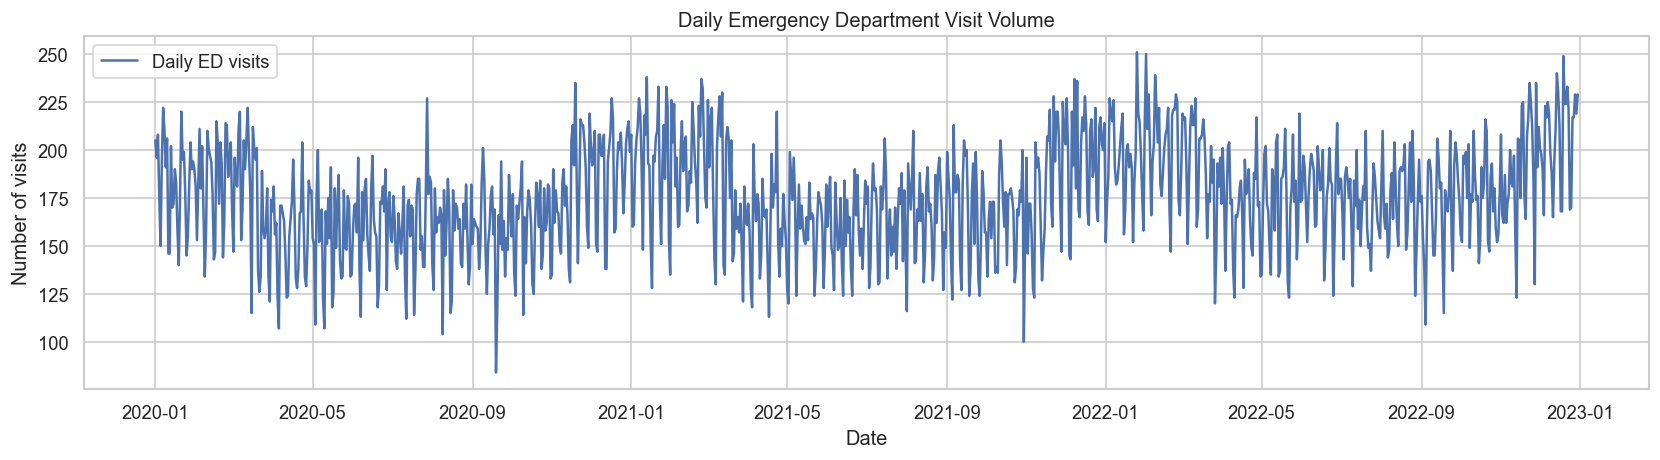

In [7]:
# STEP 5: Visualize the raw time series.
# This is where we look for trend, seasonality, and obvious anomalies.

plt.figure(figsize=(14, 4))
plt.plot(df.index, df["visits"], label="Daily ED visits")
plt.title("Daily Emergency Department Visit Volume")
plt.xlabel("Date")
plt.ylabel("Number of visits")
plt.legend()
plt.tight_layout()
plt.show()


### Rolling Mean & Standard Deviation

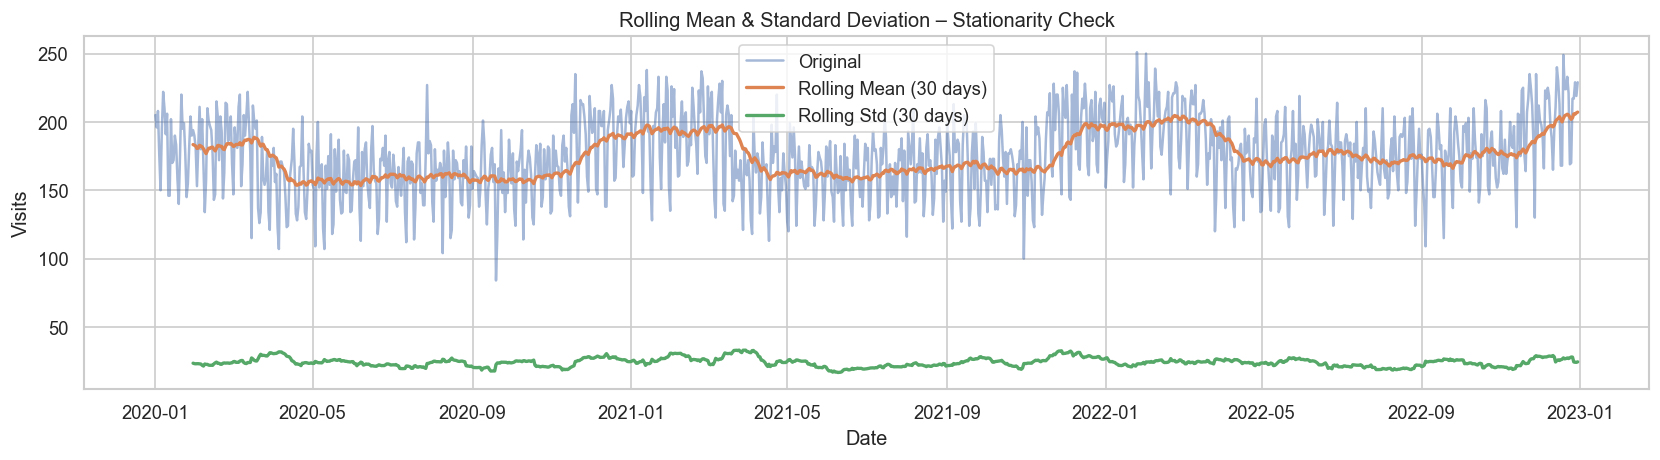

In [8]:
# STEP 6: Visual stationarity check using rolling statistics.
# If the rolling mean/std curves drift over time, the series is likely non-stationary.

window = 30  # 30-day window to represent approximately "monthly" behavior

roll_mean = df["visits"].rolling(window).mean()
roll_std = df["visits"].rolling(window).std()

plt.figure(figsize=(14, 4))
plt.plot(df.index, df["visits"], label="Original", alpha=0.5)
plt.plot(roll_mean.index, roll_mean, label=f"Rolling Mean ({window} days)", linewidth=2)
plt.plot(roll_std.index, roll_std, label=f"Rolling Std ({window} days)", linewidth=2)
plt.title("Rolling Mean & Standard Deviation – Stationarity Check")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.legend()
plt.tight_layout()
plt.show()


### ADF Test Helper Function

In [9]:
# STEP 7: Define a helper function to run the Augmented Dickey–Fuller (ADF) test.
# This gives us a formal statistical test for stationarity.

def adf_test(series, name="Series"):
    """
    Run Augmented Dickey–Fuller test and print a human-readable summary.

    Parameters
    ----------
    series : pd.Series
        The time series values (e.g., ED visits).
    name : str
        Name used in printed output for clarity.
    """
    result = adfuller(series.dropna())
    adf_stat, p_value, used_lag, n_obs, crit_values, icbest = result[0], result[1], result[2], result[3], result[4], result[5]
    
    print(f"ADF Test for {name}")
    print("-" * 40)
    print(f"ADF Statistic : {adf_stat:.4f}")
    print(f"p-value       : {p_value:.4f}")
    print(f"Used lags     : {used_lag}")
    print(f"Number of obs : {n_obs}")
    print("Critical values:")
    for key, value in crit_values.items():
        print(f"  {key}: {value:.4f}")
        
    print("\nInterpretation:")
    if p_value < 0.05:
        print("  p-value < 0.05 → Reject H0 (unit root).")
        print("  The series is likely STATIONARY.\n")
    else:
        print("  p-value ≥ 0.05 → Fail to reject H0 (unit root).")
        print("  The series is likely NON-STATIONARY.\n")


### Run ADF on Original Series

In [10]:
# STEP 8: Run ADF on the original ED visits series.
# We'll likely see non-stationarity because of trend and seasonality.

adf_test(df["visits"], name="Daily ED Visits")


ADF Test for Daily ED Visits
----------------------------------------
ADF Statistic : -2.0495
p-value       : 0.2653
Used lags     : 22
Number of obs : 1072
Critical values:
  1%: -3.4365
  5%: -2.8642
  10%: -2.5682

Interpretation:
  p-value ≥ 0.05 → Fail to reject H0 (unit root).
  The series is likely NON-STATIONARY.



### First-Order Differencing

In [11]:
# STEP 9: Apply first-order differencing to remove trend.
# This transforms Y_t into Y_t - Y_{t-1}, stabilizing the mean.

df["visits_diff"] = df["visits"].diff()

# Quick preview of original vs differenced
df[["visits", "visits_diff"]].head()


,visits,visits_diff
date,,
2020-01-01,205,NaN
2020-01-02,196,-9.0
2020-01-03,208,12.0
2020-01-04,176,-32.0
2020-01-05,150,-26.0


### Plot Differenced Series + ADF Again

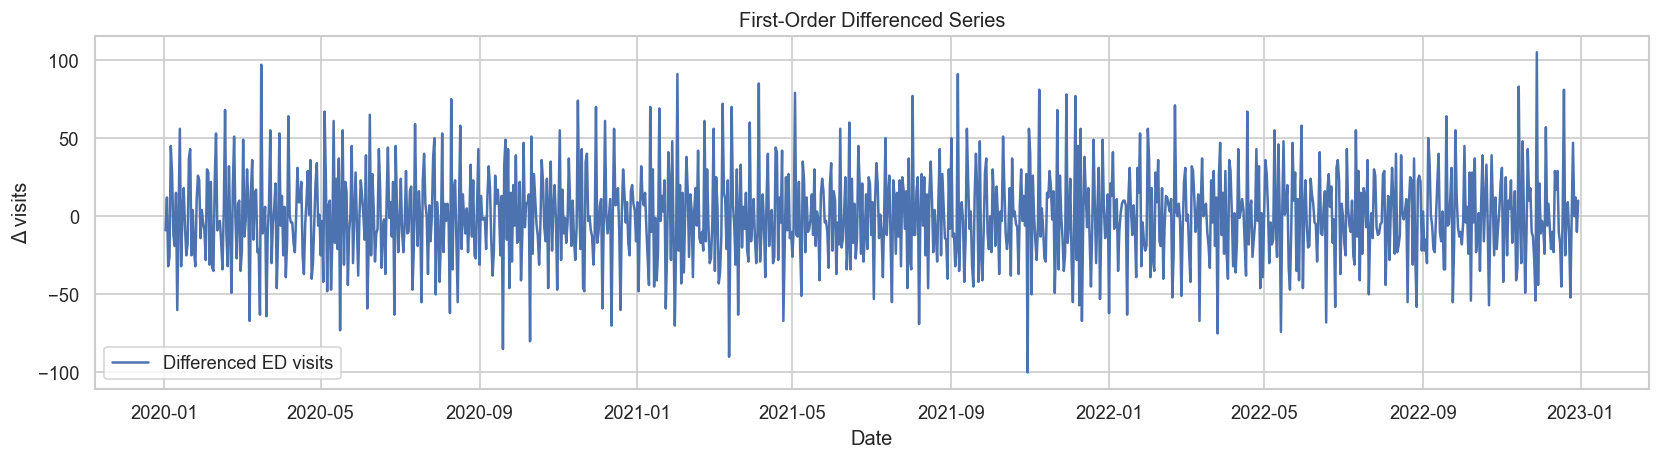

ADF Test for Differenced ED Visits
----------------------------------------
ADF Statistic : -8.7391
p-value       : 0.0000
Used lags     : 22
Number of obs : 1071
Critical values:
  1%: -3.4365
  5%: -2.8642
  10%: -2.5682

Interpretation:
  p-value < 0.05 → Reject H0 (unit root).
  The series is likely STATIONARY.



In [12]:
# Visualize the differenced series.

plt.figure(figsize=(14, 4))
plt.plot(df.index, df["visits_diff"], label="Differenced ED visits")
plt.title("First-Order Differenced Series")
plt.xlabel("Date")
plt.ylabel("Δ visits")
plt.legend()
plt.tight_layout()
plt.show()

# Run ADF again to check stationarity after differencing.
adf_test(df["visits_diff"], name="Differenced ED Visits")


### ACF & PACF on Differenced Series

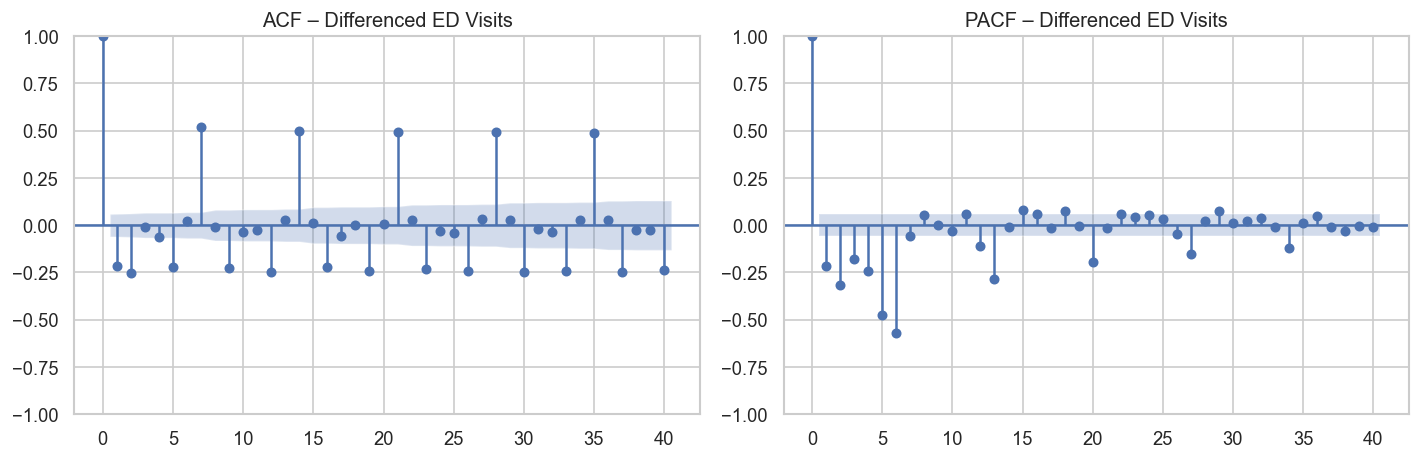

In [13]:
# STEP 10: Plot ACF and PACF to guide ARIMA(p, d, q) selection.
# We use the differenced series because AR and MA components
# are easier to see once trend is removed.

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df["visits_diff"].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF – Differenced ED Visits")

plot_pacf(df["visits_diff"].dropna(), lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF – Differenced ED Visits")

plt.tight_layout()
plt.show()


### Time-Aware Train–Test Split

In [14]:
# STEP 11: Train-test split that respects time ordering.
# We do NOT randomize time series; we simulate "training on past, predicting future."

def train_test_split_series(df, col="visits", train_ratio=0.8):
    """
    Split a time series into train and test segments in chronological order.

    Parameters
    ----------
    df : DataFrame with a datetime index.
    col : str
        Name of the column to forecast.
    train_ratio : float
        Fraction of observations to include in the training set.

    Returns
    -------
    y_train : pd.Series
    y_test  : pd.Series
    """
    n = len(df)
    split_idx = int(n * train_ratio)
    y = df[col]

    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    print(f"Train size: {len(y_train)}")
    print(f"Test size : {len(y_test)}")

    return y_train, y_test

y_train, y_test = train_test_split_series(df, col="visits", train_ratio=0.8)


Train size: 876
Test size : 219


### Fit ARIMA Model

In [15]:
# STEP 12: Fit an ARIMA model.
# Based on ACF/PACF + differencing, we start with ARIMA(1, 1, 1).

order = (1, 1, 1)
print(f"Fitting ARIMA{order} model...")

model = ARIMA(y_train, order=order)

# fit() estimates the parameters (φ, θ, etc.) based on the training data.
model_fit = model.fit()

# The summary shows coefficients, significance, and information criteria.
print(model_fit.summary())


Fitting ARIMA(1, 1, 1) model...


C:\Users\tawde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tawde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\tawde\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 visits   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4043.710
Date:                Fri, 05 Dec 2025   AIC                           8093.420
Time:                        15:41:14   BIC                           8107.743
Sample:                    01-01-2020   HQIC                          8098.899
                         - 05-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2560      0.034      7.462      0.000       0.189       0.323
ma.L1         -0.9454      0.012    -79.884      0.000      -0.969      -0.922
sigma2       603.5854     31.362     19.246      0.0

### Forecast & Confidence Intervals

In [16]:
# STEP 13: Generate forecasts for the test period.
# We forecast len(y_test) steps ahead and extract predicted means and confidence intervals.

n_steps = len(y_test)
forecast_obj = model_fit.get_forecast(steps=n_steps)

pred = forecast_obj.predicted_mean           # Point forecasts
conf = forecast_obj.conf_int()              # Confidence intervals (typically 95%)

pred.head(), conf.head()


(2022-05-26    182.574928
 2022-05-27    176.065756
 2022-05-28    174.399318
 2022-05-29    173.972686
 2022-05-30    173.863463
 Freq: D, Name: predicted_mean, dtype: float64,
             lower visits  upper visits
 2022-05-26    134.422582    230.727275
 2022-05-27    125.643759    226.487754
 2022-05-28    123.565274    225.233361
 2022-05-29    122.958483    224.986890
 2022-05-30    122.713328    225.013598)

### Plot Forecast vs Actual

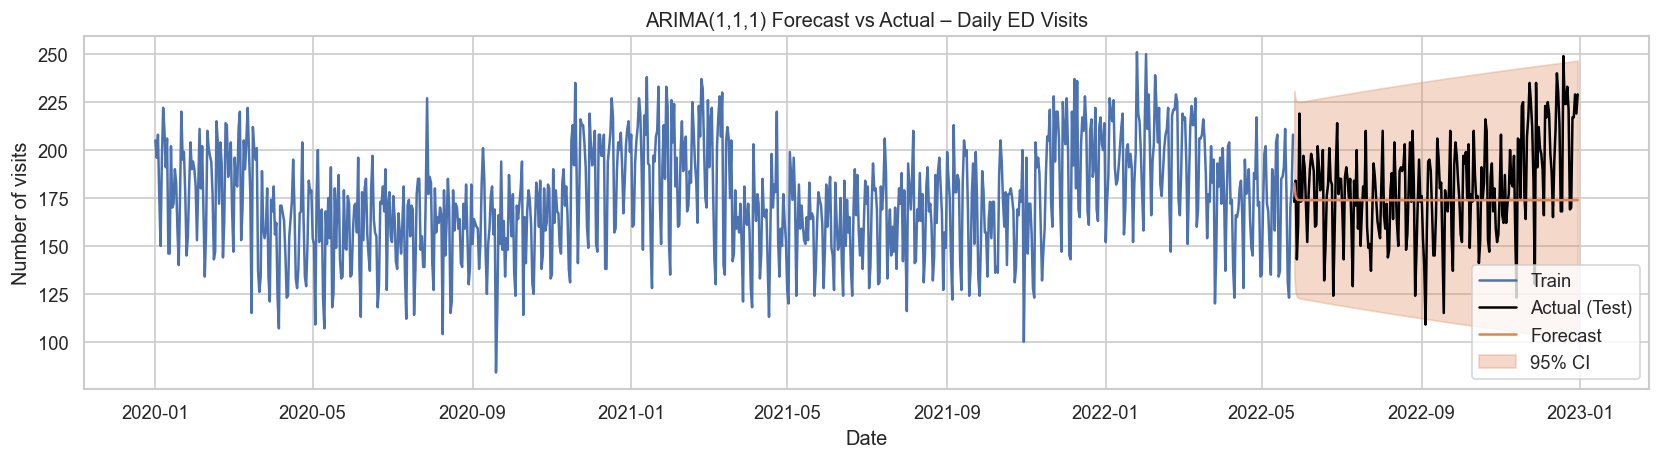

In [17]:
# STEP 14: Visual comparison of train, actual test data, and forecast.

plt.figure(figsize=(14, 4))

# Plot training data (historical past)
plt.plot(y_train.index, y_train, label="Train", color="C0")

# Plot actual future observations (ground truth)
plt.plot(y_test.index, y_test, label="Actual (Test)", color="black")

# Plot forecasts
plt.plot(pred.index, pred, label="Forecast", color="C1")

# Shade the confidence interval region
plt.fill_between(pred.index, conf.iloc[:, 0], conf.iloc[:, 1],
                 color="C1", alpha=0.3, label="95% CI")

plt.title("ARIMA(1,1,1) Forecast vs Actual – Daily ED Visits")
plt.xlabel("Date")
plt.ylabel("Number of visits")
plt.legend()
plt.tight_layout()
plt.show()


### Forecast Accuracy Metrics

In [18]:
# STEP 15: Quantitative evaluation using MAE and RMSE.

mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print("Forecast Accuracy on Test Set")
print("-" * 40)
print(f"MAE : {mae:.3f}  (average absolute error in daily visits)")
print(f"RMSE: {rmse:.3f}  (penalizes larger errors more heavily)")


Forecast Accuracy on Test Set
----------------------------------------
MAE : 21.212  (average absolute error in daily visits)
RMSE: 26.732  (penalizes larger errors more heavily)


### Residual Diagnostics

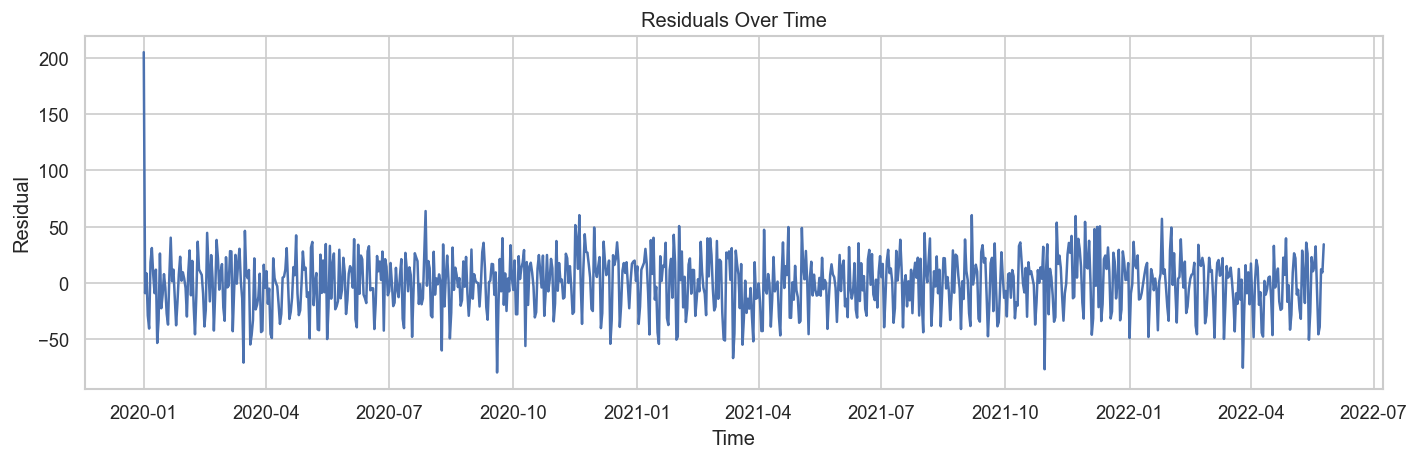

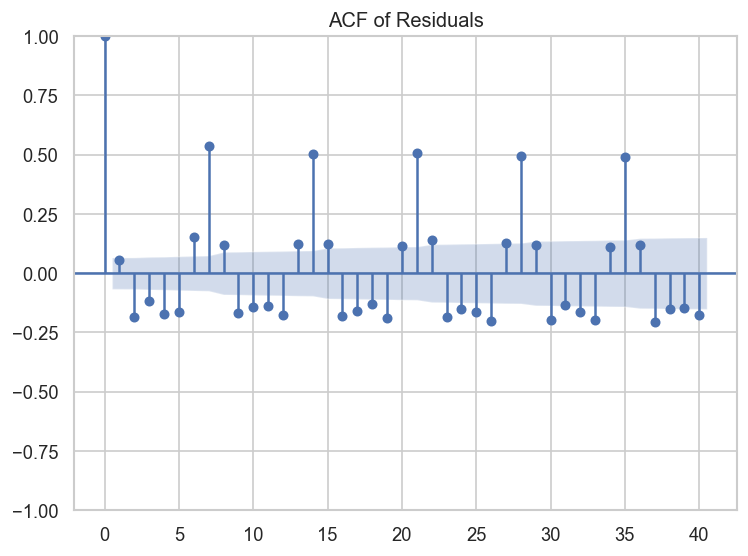

In [19]:
# STEP 16: Residual analysis.
# A good ARIMA model should leave residuals that look like white noise.

residuals = model_fit.resid

# 1) Residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 2) ACF of residuals to check remaining autocorrelation
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.tight_layout()
plt.show()


### Example Scenario B: Smaller Community Hospital

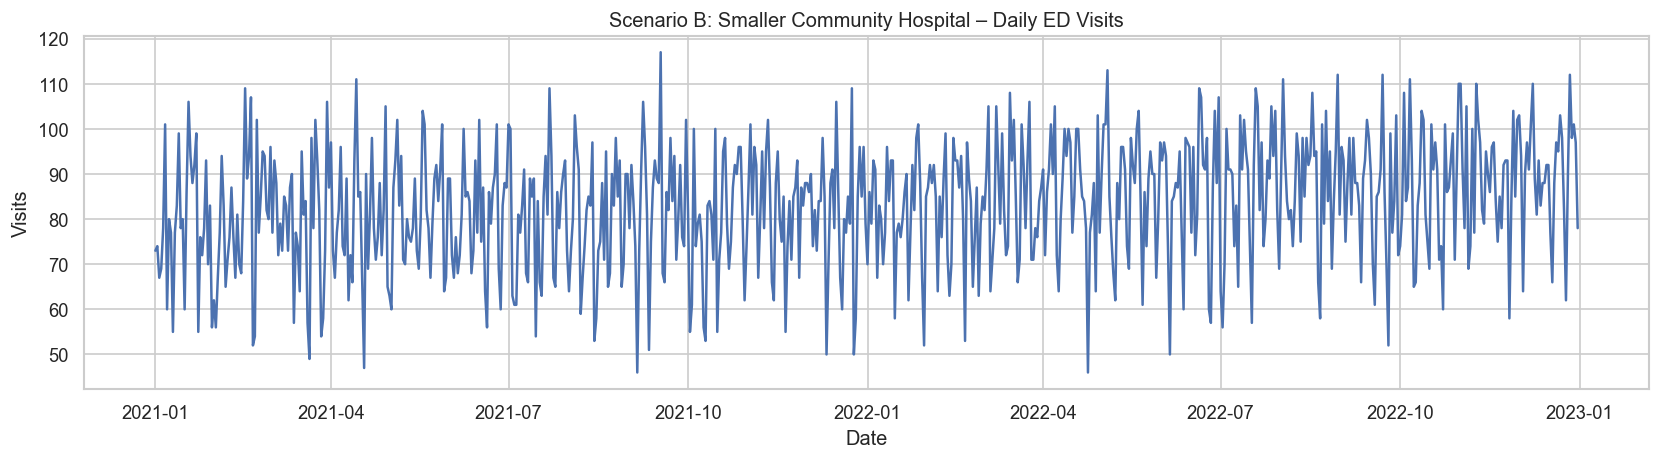

In [20]:
# OPTIONAL: Example Scenario B – Smaller community hospital with lower volume.

# This shows students how the same pipeline can be reused on a different dataset.

np.random.seed(123)

n_days_b = 2 * 365  # 2 years instead of 3
dates_b = pd.date_range(start="2021-01-01", periods=n_days_b, freq="D")

baseline_b = 80              # smaller baseline
trend_b = np.linspace(0, 10, n_days_b)
day_of_week_b = dates_b.dayofweek
weekly_pattern_b = np.where(day_of_week_b < 5, 1.05, 0.80)
noise_b = np.random.normal(0, 10, n_days_b)

visits_b = baseline_b * weekly_pattern_b + trend_b + noise_b
visits_b = np.round(np.clip(visits_b, a_min=30, a_max=None)).astype(int)

df_b = pd.DataFrame({"date": dates_b, "visits": visits_b}).set_index("date")

plt.figure(figsize=(14,4))
plt.plot(df_b.index, df_b["visits"])
plt.title("Scenario B: Smaller Community Hospital – Daily ED Visits")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.tight_layout()
plt.show()


### Interpretation Summary


### Model Behavior

- The original ED visit series showed:
  - A slow upward trend over several years.  
  - Clear weekly seasonality (weekdays ≫ weekends).  
  - Strong winter peaks (simulated flu season).  

- The ADF test on the raw series suggested non-stationarity.
- After first-order differencing, the series became stationary.
- ACF/PACF plots supported an ARIMA(1,1,1) structure.

### Forecast Quality

- MAE and RMSE quantify the average forecast error in number of patients.
- Visually, the forecast tracks the general level and patterns of the test data.
- Confidence intervals widen as we forecast further into the future → increasing uncertainty.

### Healthcare Operations Perspective

- Forecasts like these can inform:
  - Nurse staffing levels  
  - Bed and resource planning  
  - Surge preparation during winter months  

- Even a simple ARIMA model provides interpretable, actionable insights
  that administrators can trust and understand.

